### Import Necessary Library

In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import MaxPooling2D, Conv2D, UpSampling2D, Input, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.models import Model
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import time
import matplotlib.pyplot as plt

In [2]:
# to get the image's path in proper sorted order
def get_sorted_path(data):
    new_data = [int(i.split('.')[0]) for i in data]
    new_data.sort()
    converted_list = [str(i)+'.jpg' for i in new_data]
    return converted_list

In [5]:
# defining image size
IMAGE_SIZE = 128
color_img = []
path = '../input/hghgghghgh/Human_faces/color'
files = os.listdir(path)
files = get_sorted_path(files)
from sklearn.model_selection import train_test_split
for i in tqdm(files):
    img = cv2.imread(os.path.join(path, i))
    # open cv reads images in BGR format so we have to convert it to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # resizing image
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    # applying normalization
    img = img.astype('float32') / 255.0
    # appends images in color_img list
    color_img.append(img_to_array(img))
    
gray_img = []
path = '../input/hghgghghgh/Human_faces/gray'
files = os.listdir(path)
files = get_sorted_path(files)

for i in tqdm(files):
    img = cv2.imread(os.path.join(path, i))
    # resizing image
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img = img.astype('float32') / 255.0
    gray_img.append(img_to_array(img))

100%|██████████| 5749/5749 [00:23<00:00, 249.77it/s]


In [6]:
# defining function to plot images pair
def plot_image(color, grayscale):
    plt.figure(figsize = (15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'red', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
    plt.show()

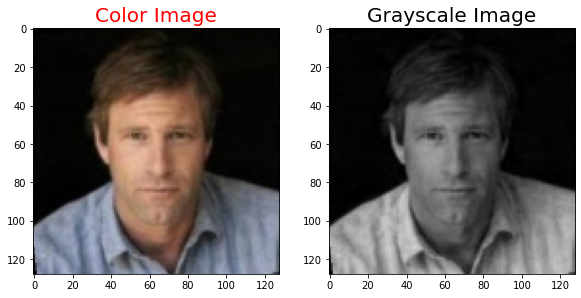

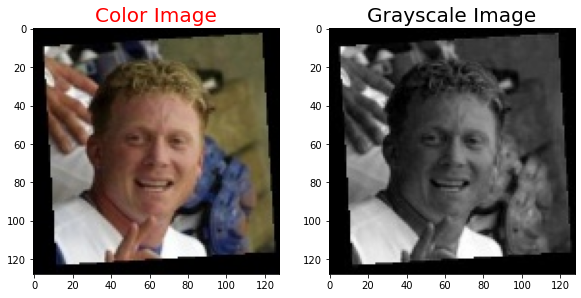

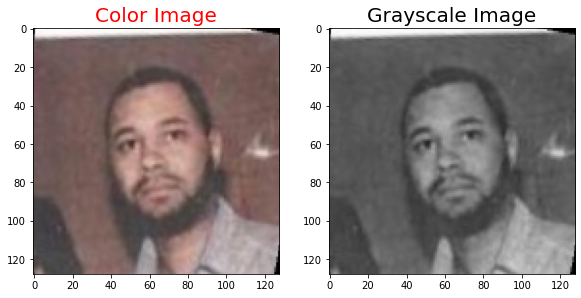

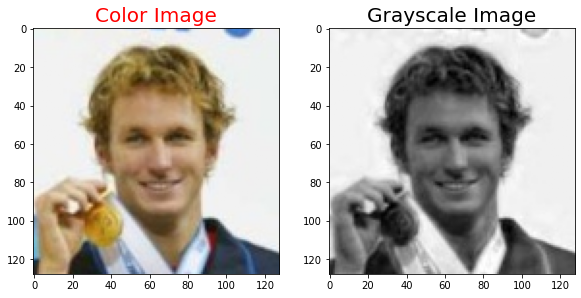

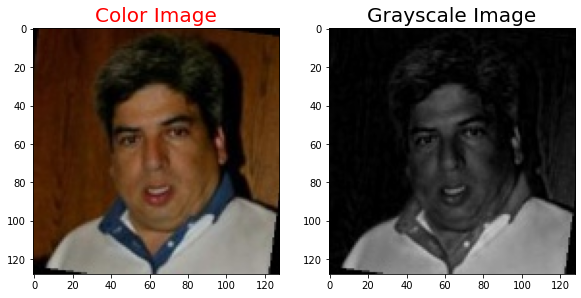

In [7]:
for i in range(5):
    plot_image(color_img[i], gray_img[i])

### Creating Training Dataset and Testing Dataset

In [8]:
#There are total 5720 images I have splited the dataset into 70:30 for training and testing the model

train_gray_image = gray_img[:4024]
train_color_image = color_img[:4024]

test_gray_image = gray_img[4024:]
test_color_image = color_img[4024:]

# reshaping
train_g = np.reshape(train_gray_image,(-1,IMAGE_SIZE, IMAGE_SIZE, 3))
train_c = np.reshape(train_color_image,(-1,IMAGE_SIZE, IMAGE_SIZE, 3))
print('Train color image shape : {}'.format(train_c.shape))

test_g = np.reshape(test_gray_image,(-1,IMAGE_SIZE, IMAGE_SIZE, 3))
test_c = np.reshape(test_color_image,(-1,IMAGE_SIZE, IMAGE_SIZE, 3))
print('Test color image shape : {}'.format(test_c.shape))

Train color image shape : (4024, 128, 128, 3)
Test color image shape : (1725, 128, 128, 3)


### Defining our Model

In [9]:
from keras import layers


# Down Sampling Layer Function
def down(filters, kernal_size, apply_batch_normalization = True):
    downsample = Sequential()
    downsample.add(Conv2D(filters, kernal_size, padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(keras.layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


# Up Sampling Layer Function
def up(filters, kernal_size, dropout = False):
    upsample = Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernal_size, padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

In [10]:
def model():
    
    # input layer
    inputs = Input(shape = (128, 128, 3))
    
    # Downsampling
    d1 = down(64, (3,3), False)(inputs)  # 64
    d2 = down(128, (3,3), True)(d1)     # 32
    d3 = down(128, (3,3), True)(d2)      # 16
    d4 = down(256, (3,3), True)(d3)      # 8
    d5 = down(512, (3,3), True)(d4)      # 4
    
    # Bottle Neck
    d6 = down(512, (3,3), True)(d5) # 2
    
    # Upsampling
    u1 = up(512, (3,3), False)(d6)  # 4
    u1 = layers.concatenate([u1,d5])
    u2 = up(256, (3,3), False)(u1)  # 8
    u2 = layers.concatenate([u2,d4]) 
    u3 = up(128, (3,3), False)(u2)  # 16
    u3 = layers.concatenate([u3,d3])
    u4 = up(128, (3,3), False)(u3)  #  32
    u4 = layers.concatenate([u4,d2])
    u5 = up(64, (3,3), False)(u4)   # 64
    u5 = layers.concatenate([u5,d1])
    
    # output layer
    u6 = up(3, (3,3), False)(u5)
    u6 = layers.concatenate([u6,inputs])
    output = Conv2D(3, (2,2), strides = 1, padding = 'same')(u6)
    
    return Model(inputs = inputs, outputs = output)

In [11]:
model = model()
model.summary()

2021-12-29 13:57:46.239725: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-29 13:57:46.349344: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-29 13:57:46.350469: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-29 13:57:46.352749: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 64, 64, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 32, 32, 128)  74368       sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 16, 16, 128)  148096      sequential_1[0][0]               
______________________________________________________________________________________________

In [12]:
model.compile(optimizer = Adam(0.001), loss = 'mean_absolute_error', metrics = ['acc'])

In [13]:
start_time = time.time()
history = model.fit(train_g, train_c, epochs = 200, batch_size = 64, verbose = 1)
end_time = time.time()

2021-12-29 13:58:01.381468: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 791150592 exceeds 10% of free system memory.
2021-12-29 13:58:02.275904: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 791150592 exceeds 10% of free system memory.
2021-12-29 13:58:03.054919: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 791150592 exceeds 10% of free system memory.
2021-12-29 13:58:03.639073: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 791150592 exceeds 10% of free system memory.
2021-12-29 13:58:04.249572: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2021-12-29 13:58:06.477307: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


63/63 [==============================] - 14s 90ms/step - loss: 0.1116 - acc: 0.4998
Epoch 2/200
63/63 [==============================] - 5s 83ms/step - loss: 0.0666 - acc: 0.6009
Epoch 3/200
63/63 [==============================] - 5s 83ms/step - loss: 0.0621 - acc: 0.6130
Epoch 4/200
63/63 [==============================] - 5s 83ms/step - loss: 0.0598 - acc: 0.6253
Epoch 5/200
63/63 [==============================] - 5s 84ms/step - loss: 0.0575 - acc: 0.6376
Epoch 6/200
63/63 [==============================] - 5s 84ms/step - loss: 0.0561 - acc: 0.6466
Epoch 7/200
63/63 [==============================] - 5s 84ms/step - loss: 0.0546 - acc: 0.6553
Epoch 8/200
63/63 [==============================] - 5s 83ms/step - loss: 0.0526 - acc: 0.6685
Epoch 9/200
63/63 [==============================] - 5s 84ms/step - loss: 0.0512 - acc: 0.6768
Epoch 10/200
63/63 [==============================] - 5s 83ms/step - loss: 0.0493 - acc: 0.6852
Epoch 11/200
63/63 [==============================] - 5s 85m

In [14]:
def convert(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
      
    return "%d:%02d:%02d" % (hour, minutes, seconds)

In [15]:
total_time_taken = convert(end_time - start_time)
print('Model took {} (HH:MM:SS) time to train'.format(total_time_taken))

Model took 0:18:26 (HH:MM:SS) time to train


In [16]:
#model.save('Autoencoder_200e.h5')

In [17]:
import matplotlib.pyplot as plt

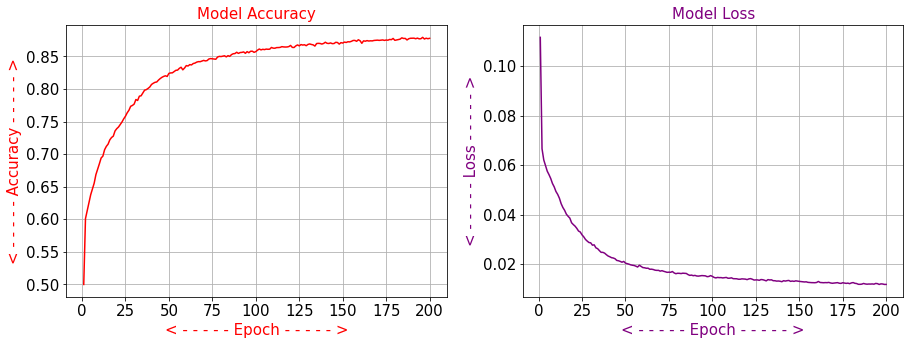

In [18]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(200)+1, history.history['acc'], color = 'r')
plt.title('Model Accuracy', color = 'red', fontsize = 15)
plt.ylabel('< - - - - - Accuracy - - - - - >', fontsize = 15, color = 'red')
plt.xlabel('< - - - - - Epoch - - - - - >', fontsize = 15, color = 'red')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('model accuracy.png')
plt.grid()

plt.subplot(1,2,2)
plt.plot(np.arange(200)+1, history.history['loss'], color= 'purple')
plt.title('Model Loss', color = 'purple', fontsize = 15)
plt.ylabel('< - - - - - Loss - - - - - >', fontsize = 15, color = 'purple')
plt.xlabel('< - - - - - Epoch - - - - - >', fontsize = 15, color = 'purple')
plt.savefig('model loss.png')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()


plt.show()

In [19]:
model.evaluate(test_g, test_c)

54/54 [==============================] - 2s 22ms/step - loss: 0.0541 - acc: 0.6381


[0.05410429462790489, 0.6380729079246521]

### After 50 epochs, We have got 74% accuracy on training dataset and 55% accuracy on testing dataset

In [20]:
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Ground Truth', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscaled Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Colorized Image', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

## Result on testing data

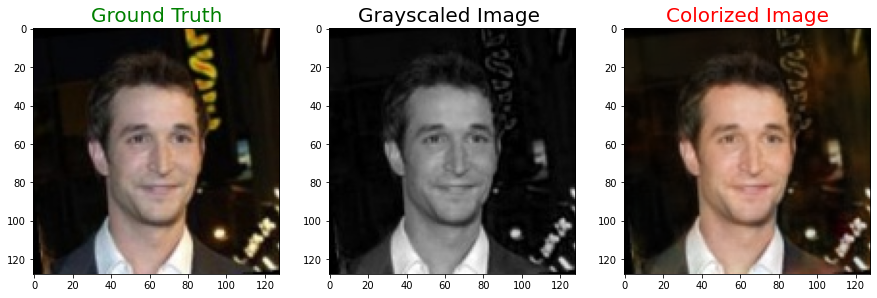

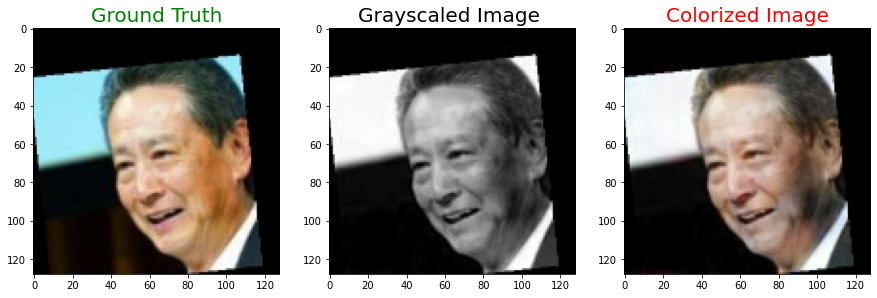

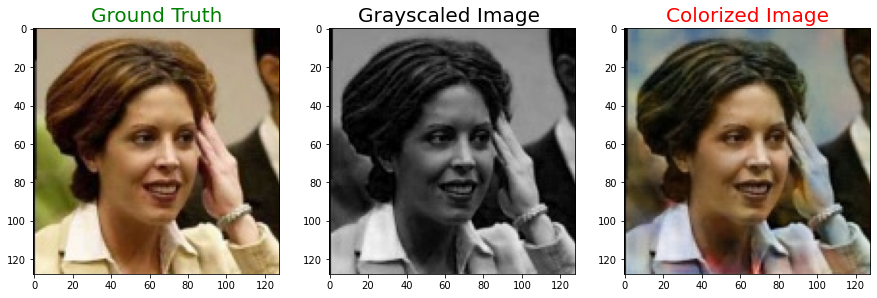

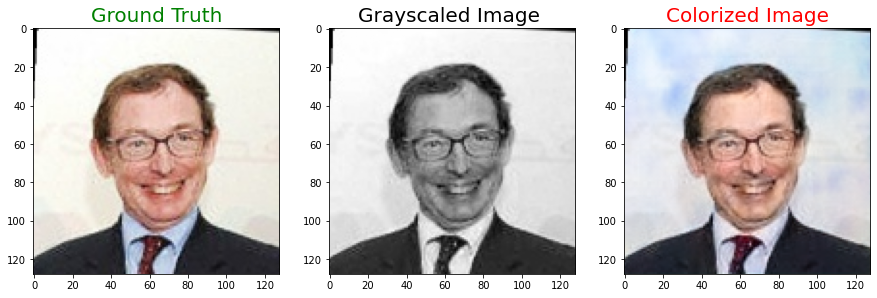

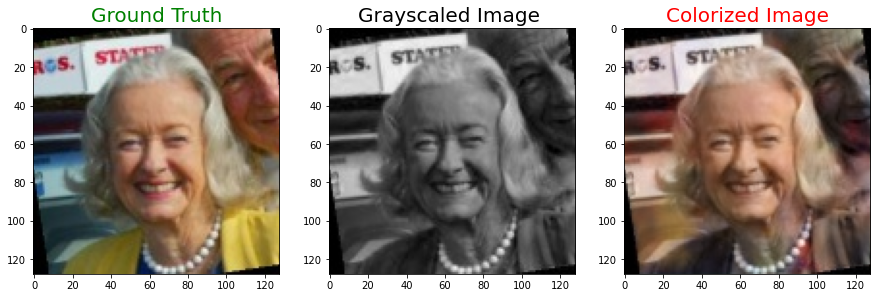

In [21]:
for i in range(80,85):
    predicted = np.clip(model.predict(test_g[i].reshape(1,IMAGE_SIZE, IMAGE_SIZE,3)),0.0,1.0).reshape(IMAGE_SIZE, IMAGE_SIZE,3)
    plot_images(test_c[i],test_g[i],predicted)

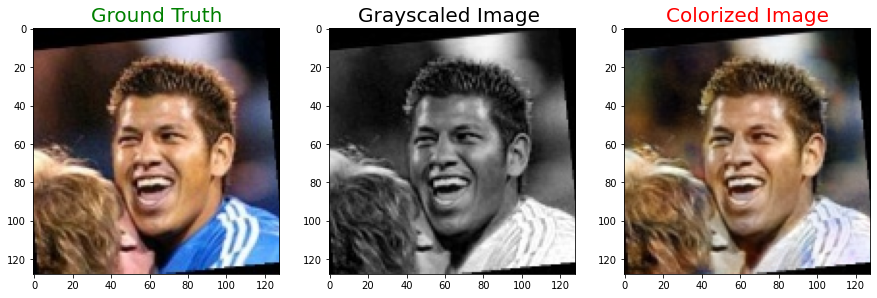

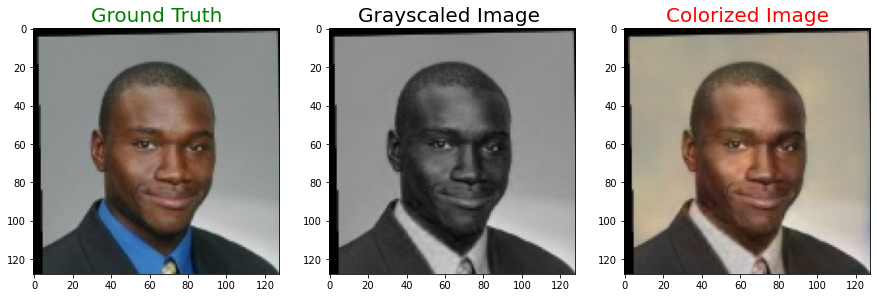

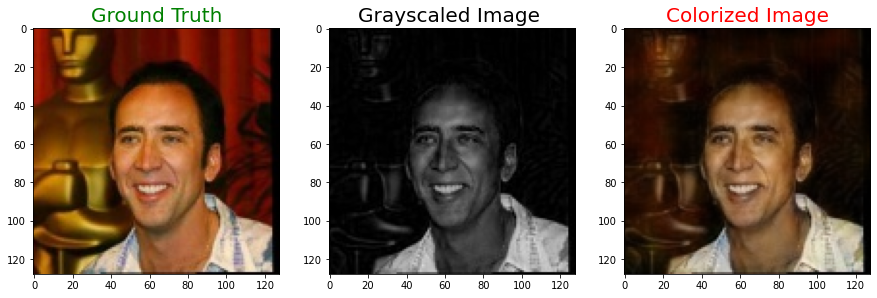

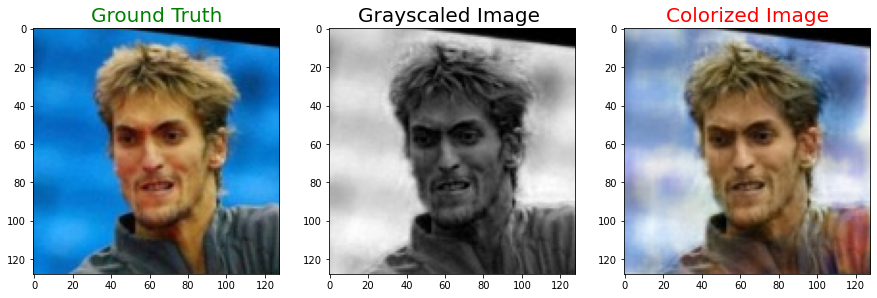

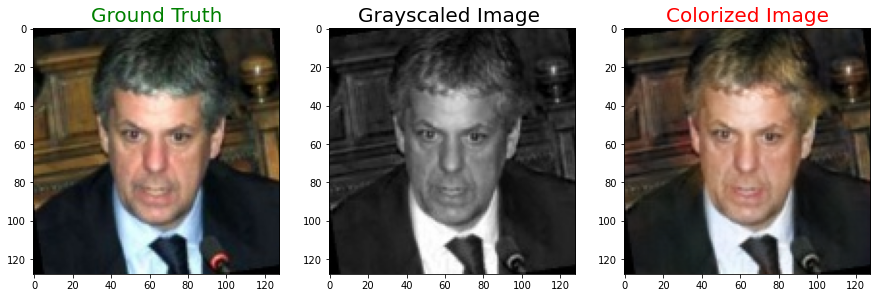

In [22]:
for i in range(50,55):
    predicted = np.clip(model.predict(test_g[i].reshape(1,IMAGE_SIZE, IMAGE_SIZE,3)),0.0,1.0).reshape(IMAGE_SIZE, IMAGE_SIZE,3)
    plot_images(test_c[i],test_g[i],predicted)

## Result on training data

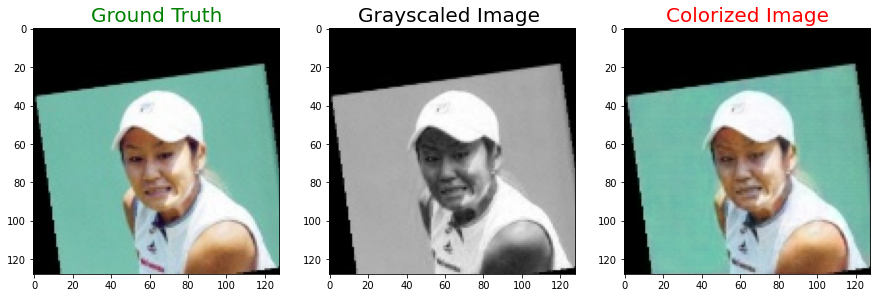

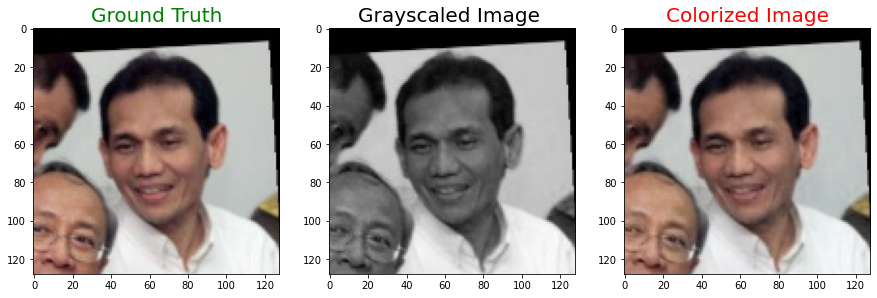

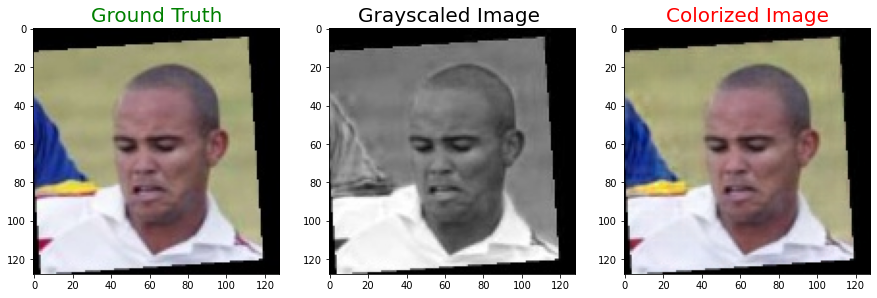

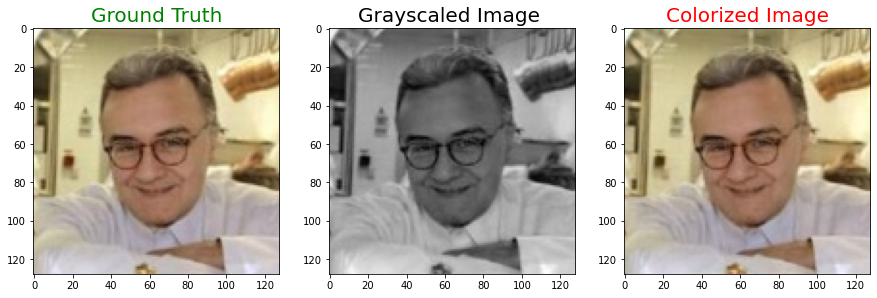

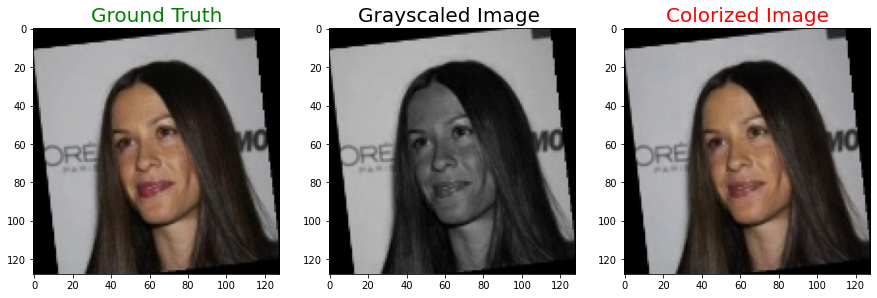

In [23]:
for i in range(80,85):
    predicted = np.clip(model.predict(train_g[i].reshape(1,IMAGE_SIZE, IMAGE_SIZE,3)),0.0,1.0).reshape(IMAGE_SIZE, IMAGE_SIZE,3)
    plot_images(train_c[i],train_g[i],predicted)

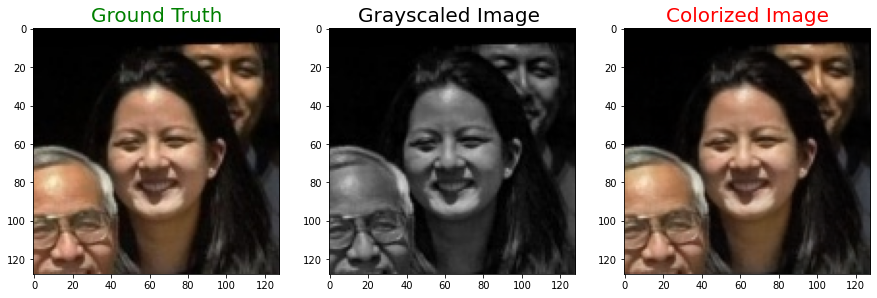

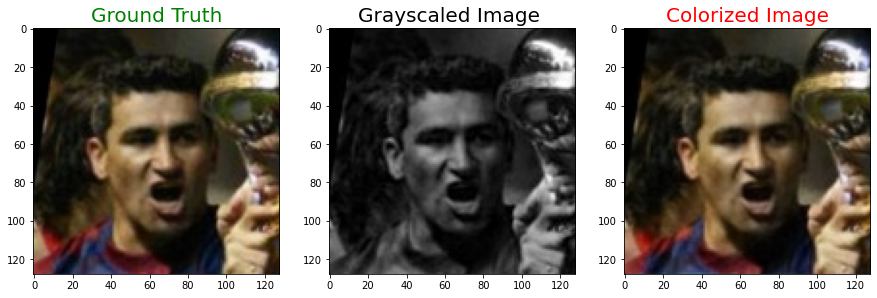

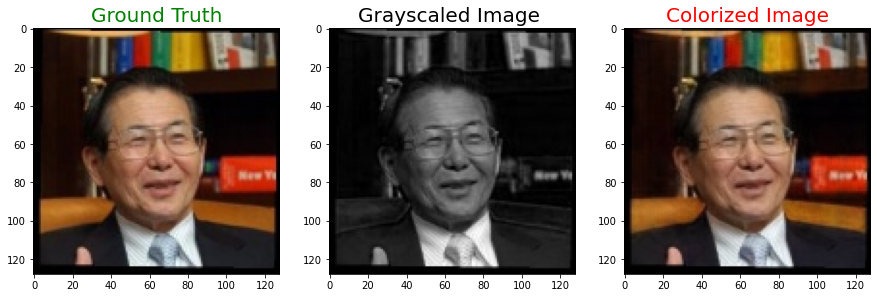

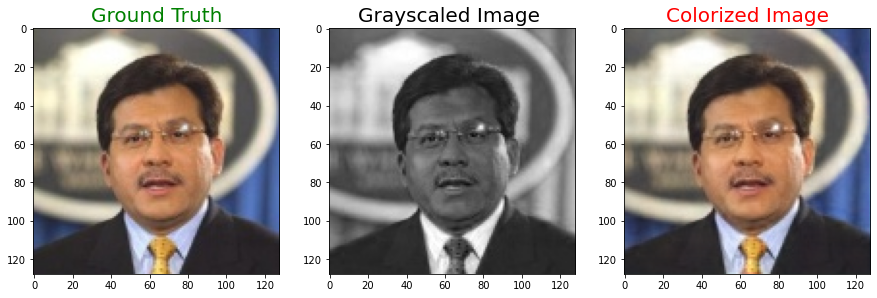

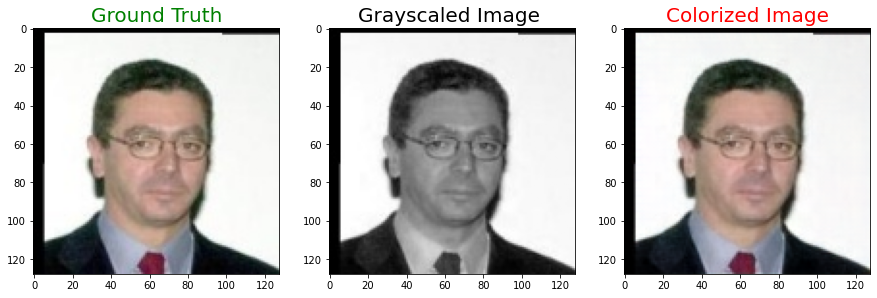

In [24]:
for i in range(100,105):
    predicted = np.clip(model.predict(train_g[i].reshape(1,IMAGE_SIZE, IMAGE_SIZE,3)),0.0,1.0).reshape(IMAGE_SIZE, IMAGE_SIZE,3)
    plot_images(train_c[i],train_g[i],predicted)

## Model Evaluation on different value of e

In [25]:
# Evaluate funtion which will return Accuracy and MAE(Mean Absolute Error) of the model
def evaluate(x,y,e,model):
    y_predicted = model.predict(x)
    MAE = np.mean(np.absolute(y_predicted-y))
    diff = np.absolute(y_predicted-y)
    count = diff <= e
    accurate_value_count = count.sum()
    total_values = x.shape[0]*IMAGE_SIZE*IMAGE_SIZE*3
    accuracy = (accurate_value_count/total_values)*100
    return accuracy,MAE

In [26]:
testing_dataset_eval = []
training_dataset_eval = []
e = [0.01, 0.03, 0.05, 0.1]

for i in e:
    testing_dataset_eval.append(evaluate(test_g, test_c, i, model))
    print(i , " Done")
print("Testing Part Done!!! ")    
for i in e:
    training_dataset_eval.append(evaluate(train_g, train_c, i, model))
    print(i ," Done")
print("All Done!!!")

0.01  Done
0.03  Done
0.05  Done
0.1  Done
Testing Part Done!!! 


2021-12-29 14:16:57.453579: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 791150592 exceeds 10% of free system memory.


0.01  Done
0.03  Done
0.05  Done
0.1  Done
All Done!!!


In [27]:
for i in range(4):
    print('e = {}'.format(e[i]))
    print()
    print('On Training Dataset : ', end="")
    print('Accuracy = {} '.format(round(training_dataset_eval[i][0]),4), end='')
    print('and MAE = ', round(training_dataset_eval[i][1],4))
    print('On Testing Dataset : ', end="")
    print('Accuracy = {} '.format(round(testing_dataset_eval[i][0])), end=' ')
    print('and MAE = ', round(testing_dataset_eval[i][1],4))
    print('----------------------------------------------------------------------------------')
    print()

e = 0.01

On Training Dataset : Accuracy = 59 and MAE =  0.0116
On Testing Dataset : Accuracy = 36  and MAE =  0.0541
----------------------------------------------------------------------------------

e = 0.03

On Training Dataset : Accuracy = 93 and MAE =  0.0116
On Testing Dataset : Accuracy = 57  and MAE =  0.0541
----------------------------------------------------------------------------------

e = 0.05

On Training Dataset : Accuracy = 98 and MAE =  0.0116
On Testing Dataset : Accuracy = 67  and MAE =  0.0541
----------------------------------------------------------------------------------

e = 0.1

On Training Dataset : Accuracy = 100 and MAE =  0.0116
On Testing Dataset : Accuracy = 83  and MAE =  0.0541
----------------------------------------------------------------------------------



# Model Loading

In [ ]:
# from keras.models import load_model
# model = load_model('Autoencoder.h5')